In [34]:
import numpy as np
import datetime

import matplotlib
import matplotlib.pyplot as plt

from scipy.optimize import minimize

import astropy.units as u
import astropy
from astropy.wcs import WCS
from astropy.time import Time
from astropy.table import Table, join, vstack
from astropy.io import fits
from astropy.visualization.wcsaxes import WCSAxes
from astropy.visualization.wcsaxes.frame import EllipticalFrame

from photutils import CircularAperture

from skycam_utils.astrometry import update_altaz, load_wcs
from skycam_utils.pipeline import get_ut, process_stellacam_image
from skycam_utils.photometry import load_skycam_catalog, load_mask
from skycam_utils.fit_wcs import wcs_zea, wcs_refine_zea

In [2]:
hdul = fits.open("image_0007410.fits")
im = hdul[0].data
hdr = hdul[0].header
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  640                                                  
NAXIS2  =                  480                                                  
EXTEND  =                    T                                                  
GAIN    =                  106                                                  
FRAME   = '256 Frames'                                                          
UT      = 'MON JUN 22 05:52:27 2020'                                            
LST     = '16:32:25.045'                                                        
AZ      =         225.87537099                                                  
EL      =          48.88659478                                                  
SCOPEX  =                  3

In [3]:
tobs = get_ut(hdr)
tobs

<Time object: scale='utc' format='datetime' value=2020-06-22 05:52:27>

In [4]:
bkg_image, diff, segm, sky_mag, joint = process_stellacam_image("image_0007410.fits", 2020, write=True, return_products=True)

Processing image_0007410.fits...


In [5]:
wcs_initial = load_wcs(year=2020)

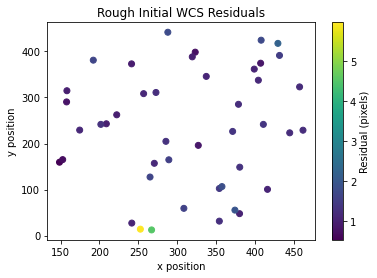

In [6]:
fit_x, fit_y = wcs_initial.all_world2pix(joint['Az'], joint['Alt'], 0)
resid_d = ((fit_x-joint['xcentroid'].value)**2+(fit_y-joint['ycentroid'].value)**2)**0.5
plt.scatter(fit_x, fit_y, c=resid_d)
cb = plt.colorbar()
cb.set_label('Residual (pixels)')
plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Rough Initial WCS Residuals')
plt.show()

In [7]:
resid_d[resid_d < 10].mean()

1.43994588278092

In [89]:

def skycam_markup(ax, wcs, alpha=0.3, color='white'):
    horizon = 15 * u.deg
    zen_x, zen_y = wcs.all_world2pix(0 * u.deg, 90 * u.deg, 0)
    n_x, n_y = wcs.all_world2pix(0 * u.deg, horizon, 0)
    e_x, e_y = wcs.all_world2pix(90 * u.deg, horizon, 0)
    s_x, s_y = wcs.all_world2pix(180 * u.deg, horizon, 0)
    w_x, w_y = wcs.all_world2pix(270 * u.deg, horizon, 0)
    rad = np.hypot(zen_x-n_x, zen_y-n_y)
    up_x, up_y = zen_x, zen_y + rad
    ang = np.arctan2(up_y-n_y, zen_x-n_x) * u.rad
    ax.plot([s_x, n_x], [s_y, n_y], color=color, alpha=alpha)
    ax.plot([e_x, w_x], [e_y, w_y], color=color, alpha=alpha)
    circle = plt.Circle((zen_x, zen_y), rad, fill=False, alpha=alpha, color=color)
    ax.add_artist(circle)
    alts = np.array([30, 45, 60, 75]) * u.deg
    for alt in alts:
        x, y = wcs.all_world2pix(0 * u.deg, alt, 0)
        r = np.hypot(zen_x-x, zen_y-y)
        cir = plt.Circle((zen_x, zen_y), r, fill=False, alpha=alpha, color=color, ls=':')
        ax.add_artist(cir)
        label = f"{int(alt.value)}" + "$^{\circ}$"
        ax.text(x, y, label, color='yellow', rotation=2*ang.to(u.deg).value, fontsize='large')
    txt_hor = 12 * u.deg
    txt_az_off = 0 * u.deg
    az = [90, 270]
    labels = ['E', 'W']
    for a, l in zip(az, labels):
        x, y = wcs.all_world2pix(a * u.deg + txt_az_off, txt_hor, 0)
        ax.text(x, y, l, color='yellow', fontsize='xx-large', horizontalalignment='center', verticalalignment='center', rotation=2*ang.to(u.deg).value)
    txt_hor = 22 * u.deg
    txt_az_off = 2 * u.deg
    az = [0, 180]
    labels = ['N', 'S']
    for a, l in zip(az, labels):
        x, y = wcs.all_world2pix(a * u.deg + txt_az_off, txt_hor, 0)
        ax.text(x, y, l, color='yellow', fontsize='xx-large', horizontalalignment='center', verticalalignment='center', rotation=2*ang.to(u.deg).value)
    
    


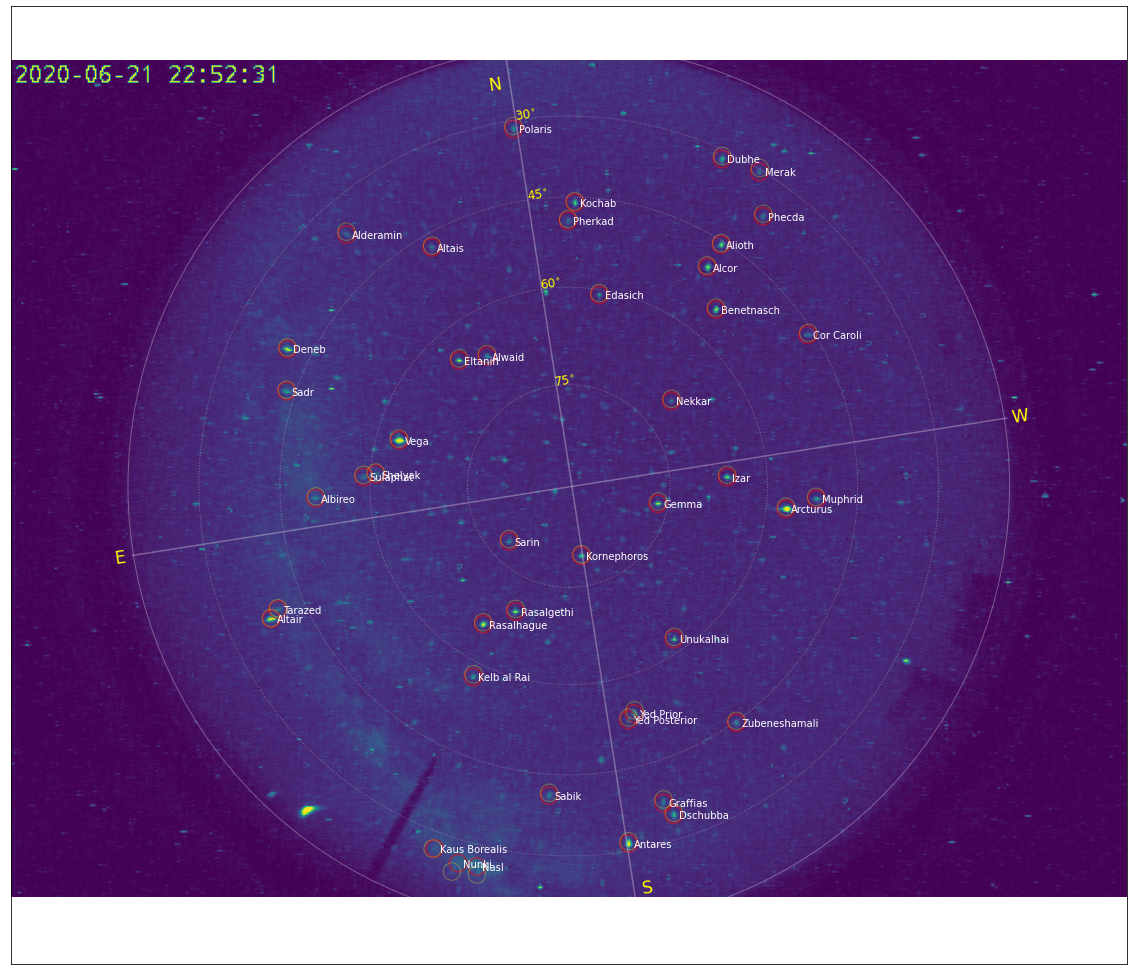

In [95]:
fig = plt.figure(figsize=[20,20])
skycat = joint[joint['Alt'] > 10.0 * u.deg]
pred_x, pred_y = wcs_initial.all_world2pix(skycat['Az'], skycat['Alt'], 0)
pred_aps = CircularAperture((pred_x, pred_y), r=5.)
aps = CircularAperture((joint['xcentroid'], joint['ycentroid']), r=5.)
#ax = plt.subplot(projection=wcs_initial)
ax = plt.subplot()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.imshow(im, origin='lower')
#ax.coords[0].set_format_unit(u.deg)
#ax.coords[0].set_auto_axislabel(False)
#ax.coords[1].set_auto_axislabel(False)
#ax.grid(color='white', ls='dotted')
aps.plot(color='red', lw=1.5, alpha=0.5)
pred_aps.plot(color='yellow', lw=1., alpha=0.3)
skycam_markup(ax, wcs_initial)
for row in joint:
    xy = (row['xcentroid'].value, row['ycentroid'].value)
    xytxt = (row['xcentroid'].value+3, row['ycentroid'].value-2)
    ax.annotate(row['Star Name'], xy, color='white', xytext=xytxt)
plt.show()

In [11]:
joint

<QTable length=44>
  HD     Vmag    U-B   ...       obs_mag                  UT          
                       ...                                            
int64  float64 float64 ...       float64                str23         
------ ------- ------- ... ------------------- -----------------------
183912    3.08    0.62 ...  -7.535250803799052 2020-06-22 05:52:27.000
116842      --      -- ...  -8.322986037721128 2020-06-22 05:52:27.000
203280    2.45    0.11 ...  -6.814779080737621 2020-06-22 05:52:27.000
112185      --      -- ...  -8.133345013315266 2020-06-22 05:52:27.000
187642      --      -- ...  -8.968435430182664 2020-06-22 05:52:27.000
180711    3.07    0.78 ...   -7.05214497359925 2020-06-22 05:52:27.000
159181      --      -- ...  -7.395214621302713 2020-06-22 05:52:27.000
148478      --      -- ...   -8.86202977939444 2020-06-22 05:52:27.000
124897   -0.05    1.28 ...  -9.148126171931652 2020-06-22 05:52:27.000
   ...     ...     ... ...                 ...                     ...
194093    2.23    0.54 ...  -8.053535594605846 2020-06-22 05:52:27.000
156164    3.13    0.08 ... -7.3324520548079954 2020-06-22 05:52:27.000
174638      --      -- ...  -7.216226812931205 2020-06-22 05:52:27.000
176437    3.24   -0.08 ...  -6.917889665205451 2020-06-22 05:52:27.000
186791    2.72    1.68 ... -7.0455647340348895 2020-06-22 05:52:27.000
140573    2.64    1.25 ...  -7.889857544929591 2020-06-22 05:52:27.000
172167    0.03     0.0 ...   -9.24872711318051 2020-06-22 05:52:27.000
146791    3.23    0.75 ... -6.8106896740019724 2020-06-22 05:52:27.000
146051    2.75    1.96 ...   -7.93877953340862 2020-06-22 05:52:27.000
135742    2.61   -0.37 ...  -7.469165662315687 2020-06-22 05:52:27.000

In [28]:
joint2019 = Table.read("../2019/astrometry.csv")

In [29]:
two_years = vstack([joint, joint2019])

ValueError: unmergeable object classes ['Quantity', 'Column']

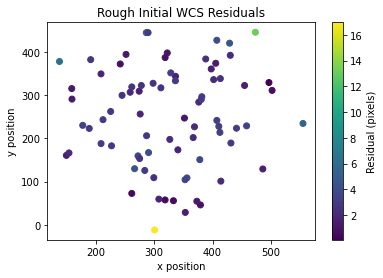

In [21]:
fit_x, fit_y = wcs_initial.all_world2pix(two_years['Az'], two_years['Alt'], 0)
resid_d = ((fit_x-two_years['xcentroid'])**2+(fit_y-two_years['ycentroid'])**2)**0.5
plt.scatter(fit_x, fit_y, c=resid_d)
cb = plt.colorbar()
cb.set_label('Residual (pixels)')
plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Rough Initial WCS Residuals')
plt.show()

In [54]:
resid_d[resid_d < 10].mean()

1.422378393056936

In [29]:
wcs_initial

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---ZEA-SIP'  'DEC--ZEA-SIP'  
CRVAL : 0.0  90.0  
CRPIX : 320.62668221556  236.19084807882  
PC1_1 PC1_2  : 0.28502705073499  0.043994506459906  
PC2_1 PC2_2  : -0.04038542897814  0.26750500846492  
CDELT : 0.92468348821396  0.98423634712595  
NAXIS : 0  0

In [38]:
fun = wcs_zea(two_years['xcentroid'], two_years['ycentroid'], two_years['Alt'], two_years['Az'], crpix1=321, crpix2=236, a_order=2, b_order=2)
init = np.array([324, 235, 1, 1, 0.3, 0.003, 0.003, 0.3])
sip_init = np.zeros(18)
x0 = np.append(init, sip_init)
#x0 = init
fit_result = minimize(fun, x0)
wcs_refined = fun.return_wcs(fit_result.x)
wcs_refined

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---ZEA-SIP'  'DEC--ZEA-SIP'  
CRVAL : 0.0  90.0  
CRPIX : 336.98101577723907  248.0616249834887  
PC1_1 PC1_2  : 0.2415536741626009  0.05735028397876812  
PC2_1 PC2_2  : -0.1022942305784001  0.24366505187217746  
CDELT : 1.117876399737312  1.0479743028405217  
NAXIS : 0  0

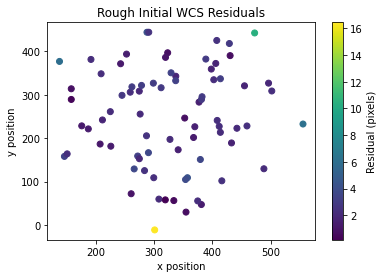

2.3007220586159525

In [39]:
fit_x, fit_y = wcs_refined.all_world2pix(two_years['Az'], two_years['Alt'], 0)
resid_d = ((fit_x-two_years['xcentroid'])**2+(fit_y-two_years['ycentroid'])**2)**0.5
plt.scatter(fit_x, fit_y, c=resid_d)
cb = plt.colorbar()
cb.set_label('Residual (pixels)')
plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Rough Initial WCS Residuals')
plt.show()
resid_d[resid_d < 10].mean()

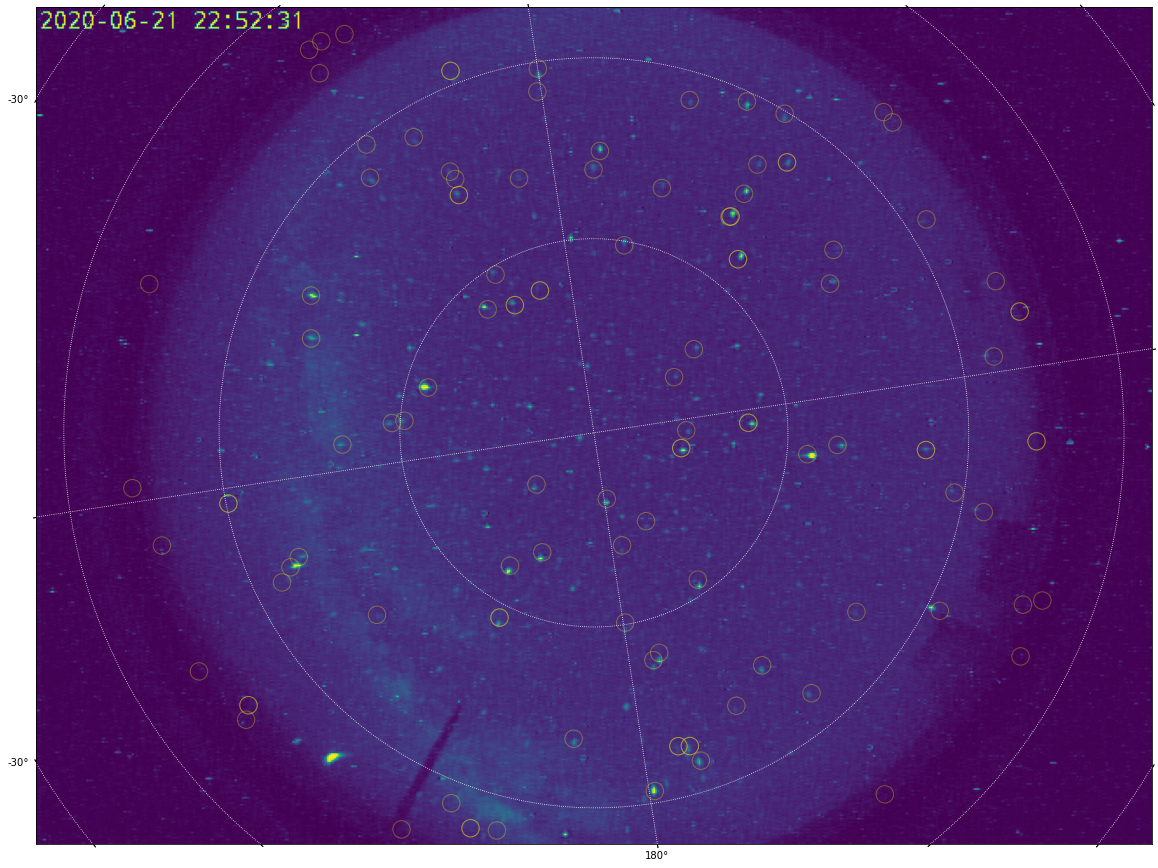

In [48]:
plt.figure(figsize=[20,20])
skycat = skycat[skycat['Alt'] > 10.0]
pred_x, pred_y = wcs_refined.all_world2pix(skycat['Az'], skycat['Alt'], 0)
init_x, init_y = wcs_initial.all_world2pix(skycat['Az'], skycat['Alt'], 0)
pred_aps = CircularAperture((pred_x, pred_y), r=5.)
init_aps = CircularAperture((init_x, init_y), r=5.)
aps = CircularAperture((joint['xcentroid'], joint['ycentroid']), r=5.)
ax = plt.subplot(projection=wcs_initial)
ax.imshow(im, origin='lower')
ax.coords[0].set_format_unit(u.deg)
ax.coords[0].set_auto_axislabel(False)
ax.coords[1].set_auto_axislabel(False)
ax.grid(color='white', ls='dotted')
#init_aps.plot(color='red', lw=1, alpha=0.5)
pred_aps.plot(color='yellow', lw=1., alpha=0.3)
plt.show()

In [43]:
wcs_refined.to_header_string()

"WCSAXES =                    2 / Number of coordinate axes                      CRPIX1  =      336.98101577724 / Pixel coordinate of reference point            CRPIX2  =      248.06162498349 / Pixel coordinate of reference point            PC1_1   =      0.2415536741626 / Coordinate transformation matrix element       PC1_2   =    0.057350283978768 / Coordinate transformation matrix element       PC2_1   =     -0.1022942305784 / Coordinate transformation matrix element       PC2_2   =     0.24366505187218 / Coordinate transformation matrix element       CDELT1  =      1.1178763997373 / [deg] Coordinate increment at reference point  CDELT2  =      1.0479743028405 / [deg] Coordinate increment at reference point  CUNIT1  = 'deg'                / Units of coordinate increment and value        CUNIT2  = 'deg'                / Units of coordinate increment and value        CTYPE1  = 'RA---ZEA'           / TAN (gnomonic) projection + SIP distortions    CTYPE2  = 'DEC--ZEA'           / TAN (g

In [57]:
new_hdr = wcs_refined.to_header( relax=0x80000)

In [58]:
new_hdr

WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =      336.98101577724 / Pixel coordinate of reference point            
CRPIX2  =      248.06162498349 / Pixel coordinate of reference point            
PC1_1   =      0.2415536741626 / Coordinate transformation matrix element       
PC1_2   =    0.057350283978768 / Coordinate transformation matrix element       
PC2_1   =     -0.1022942305784 / Coordinate transformation matrix element       
PC2_2   =     0.24366505187218 / Coordinate transformation matrix element       
CDELT1  =      1.1178763997373 / [deg] Coordinate increment at reference point  
CDELT2  =      1.0479743028405 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'RA---ZEA-SIP'       / TAN (gnomonic) projection + SIP distortions    
CTYPE2  = 'DEC--ZEA-SIP'    

In [62]:
newhdu = fits.PrimaryHDU(header=new_hdr)
newhdu.writeto("wcs_refined.fits")

In [63]:
test = WCS("wcs_refined.fits")

In [64]:
test

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---ZEA-SIP'  'DEC--ZEA-SIP'  
CRVAL : 0.0  90.0  
CRPIX : 336.98101577724  248.06162498349  
PC1_1 PC1_2  : 0.2415536741626  0.057350283978768  
PC2_1 PC2_2  : -0.1022942305784  0.24366505187218  
CDELT : 1.1178763997373  1.0479743028405  
NAXIS : 0  0

In [65]:
test.has_distortion

True

In [68]:
astropy.wcs.utils.proj_plane_pixel_scales(test)

array([0.29052861, 0.26327968])